In [103]:

import pandas as pd
import re
import torch

# 加载CSV文件
file_path = '/Users/coco/Downloads/learning_chatbot/data/dataset2.csv'
df = pd.read_csv(file_path)

# 检查数据框架的前几行
print(df.head())

# 删除缺失值
df.dropna(inplace=True)

# 清理文本数据，去除多余的空格和不必要的符号
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)  # 删除多余的空格
    text = text.strip()  # 删除首尾空格
    return text

df['Question'] = df['Question'].apply(clean_text)
df['Answer'] = df['Answer'].apply(clean_text)

# 验证清理后的数据
print(df.head())

                                            Question  \
0              What is supervised machine learning?    
1  What is regression? Which models can you use t...   
2     What is linear regression? When do we use it?    
3  What are the main assumptions of linear regres...   
4  What is the normal distribution? Why do we car...   

                                              Answer  
0  Supervised learning is a type of machine learn...  
1  Regression is a part of supervised ML. Regress...  
2  Linear regression is a model that assumes a li...  
3  There are several assumptions of linear regres...  
4  The normal distribution is a continuous probab...  
                                            Question  \
0               What is supervised machine learning?   
1  What is regression? Which models can you use t...   
2      What is linear regression? When do we use it?   
3  What are the main assumptions of linear regres...   
4  What is the normal distribution? Why do we car... 

In [104]:
# 将问题和答案组合成适合微调的格式
data = []
for index, row in df.iterrows():
    # 使用更自然的提示方式来构建prompt
    prompt = f"{row['Question']}\nPlease provide a detailed explanation:"
    
    # 确保completion部分只包含答案，并去除前面的空格
    completion = f"{row['Answer']}"
    
    data.append({'prompt': prompt, 'completion': completion})

# 将格式化的数据保存为JSON文件以供训练使用
import json

formatted_file_path = '/Users/coco/Downloads/learning_chatbot/data/formatted_dataset.jsonl'
with open(formatted_file_path, 'w') as outfile:
    for entry in data:
        json.dump(entry, outfile)
        outfile.write('\n')

# 确认数据是否正确格式化
print(data[:3])

[{'prompt': 'What is supervised machine learning?\nPlease provide a detailed explanation:', 'completion': 'Supervised learning is a type of machine learning in which our algorithms are trained using well-labeled training data, and machines predict the output based on that data. Labeled data indicates that the_input data has already been tagged with the appropriate output. Basically, it is the task of learning a function that maps the input set and returns an output. Some of its examples are: Linear Regression, Logistic Regression, KNN, etc.'}, {'prompt': 'What is regression? Which models can you use to solve a regression problem?\nPlease provide a detailed explanation:', 'completion': 'Regression is a part of supervised ML. Regression models investigate the relationship between a dependent (target) and independent variable (s) (predictor). Here are some common regression models - *Linear Regression* establishes a linear relationship between target and predictor (s). It predicts a numer

Prompt长度统计:
count    166.000000
mean      12.716867
std        5.139091
min        4.000000
25%       10.000000
50%       11.500000
75%       15.000000
max       31.000000
Name: prompt_length, dtype: float64

Completion长度统计:
count    166.000000
mean      79.789157
std       69.867217
min        2.000000
25%       37.250000
50%       61.500000
75%      108.500000
max      531.000000
Name: completion_length, dtype: float64


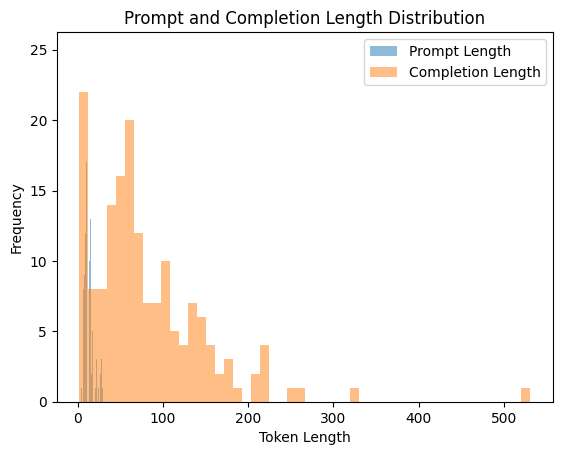

In [105]:
# 计算每个prompt和completion的长度
df['prompt_length'] = df['Question'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=False)))
df['completion_length'] = df['Answer'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=False)))

# 打印长度统计信息
print("Prompt长度统计:")
print(df['prompt_length'].describe())

print("\nCompletion长度统计:")
print(df['completion_length'].describe())

# 可视化长度分布（如果需要）
import matplotlib.pyplot as plt

plt.hist(df['prompt_length'], bins=50, alpha=0.5, label='Prompt Length')
plt.hist(df['completion_length'], bins=50, alpha=0.5, label='Completion Length')
plt.legend(loc='upper right')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.title('Prompt and Completion Length Distribution')
plt.show()


In [106]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer, Trainer, TrainingArguments
from datasets import load_dataset
import torch


# Load pre-trained model and tokenizer
model_name = 'gpt2'  # You can use other models as well
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Load your formatted dataset
dataset = load_dataset('json', data_files=formatted_file_path, split='train')

tokenizer.pad_token = tokenizer.eos_token

# Tokenize the dataset
# 定义tokenize函数
def tokenize_function(examples):
    # 确保 inputs 和 labels 都使用相同的 tokenization 方式
    inputs = tokenizer(examples["prompt"], padding="max_length", truncation=True, max_length=200)
    labels = tokenizer(examples["completion"], padding="max_length", truncation=True, max_length=200)
    inputs["labels"] = labels["input_ids"]
    return inputs
    
# 使用map函数对数据进行tokenize
tokenized_datasets = dataset.map(tokenize_function, batched=True)


# Fine-tuning arguments
training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,
    num_train_epochs=20,
    per_device_train_batch_size=4,
    save_steps=500,
    save_total_limit=2,
    learning_rate=5e-5,  # 调整学习率
    prediction_loss_only=True,  # 只计算损失
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets,
    tokenizer=tokenizer,  # 确保tokenizer被传递
    data_collator=lambda data: {
        'input_ids': torch.tensor([f["input_ids"] for f in data]),
        'attention_mask': torch.tensor([f["attention_mask"] for f in data]),
        'labels': torch.tensor([f["labels"] for f in data])
    }
)
# Fine-tune the model
trainer.train()


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/166 [00:00<?, ? examples/s]

Step,Training Loss
500,2.825000


TrainOutput(global_step=840, training_loss=2.6307755243210567, metrics={'train_runtime': 435.6656, 'train_samples_per_second': 7.621, 'train_steps_per_second': 1.928, 'total_flos': 338863104000000.0, 'train_loss': 2.6307755243210567, 'epoch': 20.0})

In [109]:
# 保存微调后的模型
model.save_pretrained('/Users/coco/Downloads/learning_chatbot/models/qa_model')
tokenizer.save_pretrained('/Users/coco/Downloads/learning_chatbot/models/qa_model')

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


('/Users/coco/Downloads/learning_chatbot/models/qa_model/tokenizer_config.json',
 '/Users/coco/Downloads/learning_chatbot/models/qa_model/special_tokens_map.json',
 '/Users/coco/Downloads/learning_chatbot/models/qa_model/vocab.json',
 '/Users/coco/Downloads/learning_chatbot/models/qa_model/merges.txt',
 '/Users/coco/Downloads/learning_chatbot/models/qa_model/added_tokens.json')

In [110]:
from transformers import pipeline

# 加载微调后的模型
qa_pipeline = pipeline('text-generation', model='/Users/coco/Downloads/learning_chatbot/models/qa_model')


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [111]:
questions = [
    "What is supervised machine learning?",
    "What methods for solving linear regression do you know? ",
    "What is the normal distribution? Why do we care about it? "
]

# 使用模型生成答案
for question in questions:
    prompt = f"Q: {question}\nA:"
    answers = qa_pipeline(
    prompt, 
    max_length=120, 
    temperature=0.5, 
    top_k=38, 
    top_p=0.85,
    repetition_penalty=2.0
)
    generated_text = answers[0]['generated_text']
    print(f"Q: {question}\nA: {generated_text}\n")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Q: What is supervised machine learning?
A: Q: What is supervised machine learning?
A: Machine Learning a the features are, of-. The - and we can model or learn in an to be as for training with ( data which) that output on feature not input want same dataset each items impurity problem need other

Q: What methods for solving linear regression do you know? 
A: Q: What methods for solving linear regression do you know? 
A:. In, to a) ( theigen_ of * or and/or- which^{_{X} is}{\math x}) -(x coefficients y),y by1= sum2 squared squares" befitting with` as are can solve that problem it matrix ` X values Y coefficient square inrender hyperBias `` +axis B _ = where value <="true">%> true bias False negative Negative positive Positive false negatives zero 0

Q: What is the normal distribution? Why do we care about it? 
A: Q: What is the normal distribution? Why do we care about it? 
A:. a of, or in- there regular curve that are other features to be skewed one and not all as (%)>/** mean variance

# 